# Load Needed Packages

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jar
# jax.config.update('jax_platform_name', 'cuda')
# jax.config.update("jax_enable_x64", False)
import numpy as np
from pandora import models, utils, GWBFunctions
from pandora import LikelihoodCalculator as LC
from enterprise_extensions.model_utils import get_tspan
import pickle, json, os, corner, glob, random, copy, time, inspect
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines

plt.style.use('dark_background')
hist_settings = dict(
    bins = 40,
    histtype = 'step',
    lw = 3,
    density = True
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

/home/koonima/anaconda3/envs/pandora/lib/python3.11/site-packages/pandora/GWBFunctions.py:11: UserWarning: The package `interpax` is needed for spline interpolation of ORF.
  warnings.warn("The package `interpax` is needed for spline interpolation of ORF.")


Optional mpi4py package is not installed.  MPI support is not available.


# Choose a data set

In [2]:
datadir = '/home/koonima/FAST/Data/Pickle/'
with open(datadir + f'v1p1_de440_pint_bipm2019.pkl', 'rb') as fin:
    psrs = pickle.load(fin)
psrlist = [psr.name for psr in psrs]
with open(datadir + f'v1p1_all_dict.json', 'r') as fin:
    noise_dict = json.load(fin)
inc_ecorr = True
backend = 'backend'
tnequad = False

libstempo not installed. PINT or libstempo are required to use par and tim files.


# Step 1: Model Construction

## Frequency-bins

In [3]:
Tspan = get_tspan(psrs) # The time-span of the entire PTA
crn_bins = 14 # number of frequency-bins for the GWB
int_bins = 30 # number of frequency-bins for the non-GWB (IRN) red noise
assert int_bins >= crn_bins
f_intrin = jnp.arange(1/Tspan, (int_bins + 0.01)/Tspan, 1/Tspan) # an array of frequency-bins for the IRN process
f_common = f_intrin[:crn_bins] # an array of frequency-bins for the common process
renorm_const = 1 # the factor by which the units are going to change (divided by). Set it to `1` for no unit change (seconds), or let it be `1e9` (nano seconds)

## GWB PSD Model 1

In [4]:
chosen_psd_model1, chosen_orf_model1, gwb_helper_dictionary1 = utils.varied_gamma_hd_pl(renorm_const=renorm_const, lower_amp=-18.0, upper_amp=-11.0)
gwb_helper_dictionary1

{'ordered_gwb_psd_model_params': array(['log10_A', 'gamma'], dtype='<U7'),
 'varied_gwb_psd_params': [np.str_('log10_A'), np.str_('gamma')],
 'gwb_psd_param_lower_lim': Array([-18.,   0.], dtype=float64),
 'gwb_psd_param_upper_lim': Array([-11.,   7.], dtype=float64)}

In [5]:
o1 = models.UniformPrior(gwb_psd_func = chosen_psd_model1,
                orf_func = chosen_orf_model1,
                crn_bins = crn_bins,
                int_bins = int_bins,
                f_common = f_common, 
                f_intrin = f_intrin,
                df = 1/Tspan,
                Tspan = Tspan, 
                Npulsars = len(psrs),
                psr_pos = [psr.pos for psr in psrs],
                gwb_helper_dictionary = gwb_helper_dictionary1,
                gamma_min = 0,
                gamma_max = 7,
                log10A_min = -20. + 0.5 * jnp.log10(renorm_const), #`0.5 * jnp.log10(renorm_const)` is added to account for change in units,
                log10A_max = -11. + 0.5 * jnp.log10(renorm_const), #`0.5 * jnp.log10(renorm_const)` is added to account for change in units,
                renorm_const = renorm_const)

In [6]:
m1  = LC.MultiPulsarModel(psrs = psrs,
                        device_to_run_likelihood_on = 'cuda',
                        TNr=jnp.array([False]),
                        TNT=jnp.array([False]),
                        run_type_object = o1,
                        noise_dict = noise_dict, 
                        backend = 'backend', 
                        tnequad = False, 
                        inc_ecorr = True, 
                        del_pta_after_init = True,
                        matrix_stabilization = False)

Package `fastshermanmorrison` not installed. Fallback to sherman-morrison


## GWB PSD Model 2

In [7]:
chosen_psd_model2, chosen_orf_model2, gwb_helper_dictionary2 = utils.varied_gamma_hd_pl(renorm_const=renorm_const, lower_amp=-18.0, upper_amp=-11.0)
gwb_helper_dictionary2

{'ordered_gwb_psd_model_params': array(['log10_A', 'gamma'], dtype='<U7'),
 'varied_gwb_psd_params': [np.str_('log10_A'), np.str_('gamma')],
 'gwb_psd_param_lower_lim': Array([-18.,   0.], dtype=float64),
 'gwb_psd_param_upper_lim': Array([-11.,   7.], dtype=float64)}

In [8]:
o2 = models.UniformPrior(gwb_psd_func = chosen_psd_model2,
                orf_func = chosen_orf_model2,
                crn_bins = crn_bins,
                int_bins = int_bins,
                f_common = f_common, 
                f_intrin = f_intrin,
                df = 1/Tspan,
                Tspan = Tspan, 
                Npulsars = len(psrs),
                psr_pos = [psr.pos for psr in psrs],
                gwb_helper_dictionary = gwb_helper_dictionary2,
                gamma_min = 0,
                gamma_max = 7,
                log10A_min = -20 + 0.5 * jnp.log10(renorm_const), #`0.5 * jnp.log10(renorm_const)` is added to account for change in units,
                log10A_max = -11 + 0.5 * jnp.log10(renorm_const), #`0.5 * jnp.log10(renorm_const)` is added to account for change in units,
                renorm_const = renorm_const)

In [9]:
m2  = LC.CURN(psrs = psrs,
                device_to_run_likelihood_on = 'cuda',
                TNr=jnp.array([False]),
                TNT=jnp.array([False]),
                run_type_object = o2,
                noise_dict = noise_dict, 
                backend = 'backend', 
                tnequad = False, 
                inc_ecorr = True, 
                del_pta_after_init = True,
                matrix_stabilization = True)

The delta is 1e-06
The max condition number of the TNT matrix before stabilizing is: 2.0092837977388298e+18
The max condition number of the TNT matrix after stabilizing is: 9.110305305490688e+12


# Construct the HM

In [10]:
hm_object = LC.TwoModelHyperModel(model1=m1, model2=m2, 
                                    log_weights = [0., np.log(250)], device='cuda'
                                    )

In [11]:
x0 = hm_object.make_initial_guess(101)
x0[-1] = 0.4
x0.shape

(139,)

In [12]:
hm_object.get_lnliklihood(x0), hm_object.get_lnprior(x0)

(Array(45243.27389851, dtype=float64),
 Array(-8.01, dtype=float64, weak_type=True))

In [13]:
x0 = hm_object.make_initial_guess(101)
x0[-1] = 0.9
x0.shape

(139,)

In [14]:
hm_object.get_lnliklihood(x0), hm_object.get_lnprior(x0)

(Array(42576.81034547, dtype=float64),
 Array(-8.01, dtype=float64, weak_type=True))

In [15]:
x0 = hm_object.make_initial_guess_jax(jar.key(100))
x0.shape

(139,)

In [16]:
# %timeit hm_object.get_lnliklihood(x0)

In [17]:
# %timeit hm_object.get_lnprior(x0)

In [18]:
# %timeit hm_object.model1.get_lnliklihood(x0[:-3])

## Sampling

In [ ]:
hm_object.sample(x0 = np.array(x0), niter = int(6e6), savedir = '../testnew/HM/', 
         resume=True)

# numpyro NUTS Sampler (experimental for HM)

In [20]:
import numpyro
from numpyro import distributions as dist
from numpyro import infer

/home/koonima/anaconda3/envs/pandora/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# ll1 = jnp.array(m1.lower_prior_lim_all)
# ul1 = jnp.array(m1.upper_prior_lim_all)

# ll2 = jnp.array(m2.lower_prior_lim_all)
# ul2 = jnp.array(m2.upper_prior_lim_all)

ll = jnp.array(hm_object.lower_prior_lim_all)[:-1]
ul = jnp.array(hm_object.upper_prior_lim_all)[:-1]

In [22]:
ll.shape, ul.shape

((138,), (138,))

In [23]:
def model():

    probs = numpyro.sample("probs", dist.Uniform(low = 0., high = 1.))
    nmodel = numpyro.sample("nmodel", dist.Categorical(jnp.array([probs, 1-probs])))
    xs = numpyro.sample("p1s", dist.Uniform(low = ll, high = ul))

    idxs = jax.lax.cond(nmodel, hm_object.x_to_x2_indices, hm_object.x_to_x1_indices)

    lik = jax.lax.cond(
            nmodel,
            m2.get_lnliklihood,
            m1.get_lnliklihood,
            xs[idxs],
        )
    numpyro.factor("lnlik", lik)

In [24]:
infer_object = infer.MCMC(
    infer.NUTS(model),
    num_warmup=250,
    num_samples=int(1e4) + 250,
    num_chains=4,
    progress_bar=True,
    chain_method='vectorized')


In [25]:
# infer_object.run(jax.random.key(100))

In [ ]:
kernel = infer.DiscreteHMCGibbs(infer.NUTS(model), modified=True)
mcmc = infer.MCMC(kernel, num_warmup=250, num_samples=4000, progress_bar=True, num_chains=1,chain_method=jax.vmap)
mcmc.run(jax.random.key(100))

warmup:   0%|          | 6/4250 [00:58<18:20:03, 15.55s/it, 63 steps of size 5.53e-06. acc. prob=0.02]

In [ ]:
samps = mcmc.get_samples()
samps

{'nmodel': Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1,

In [ ]:
samps['p1s'].shape

(1000, 139)

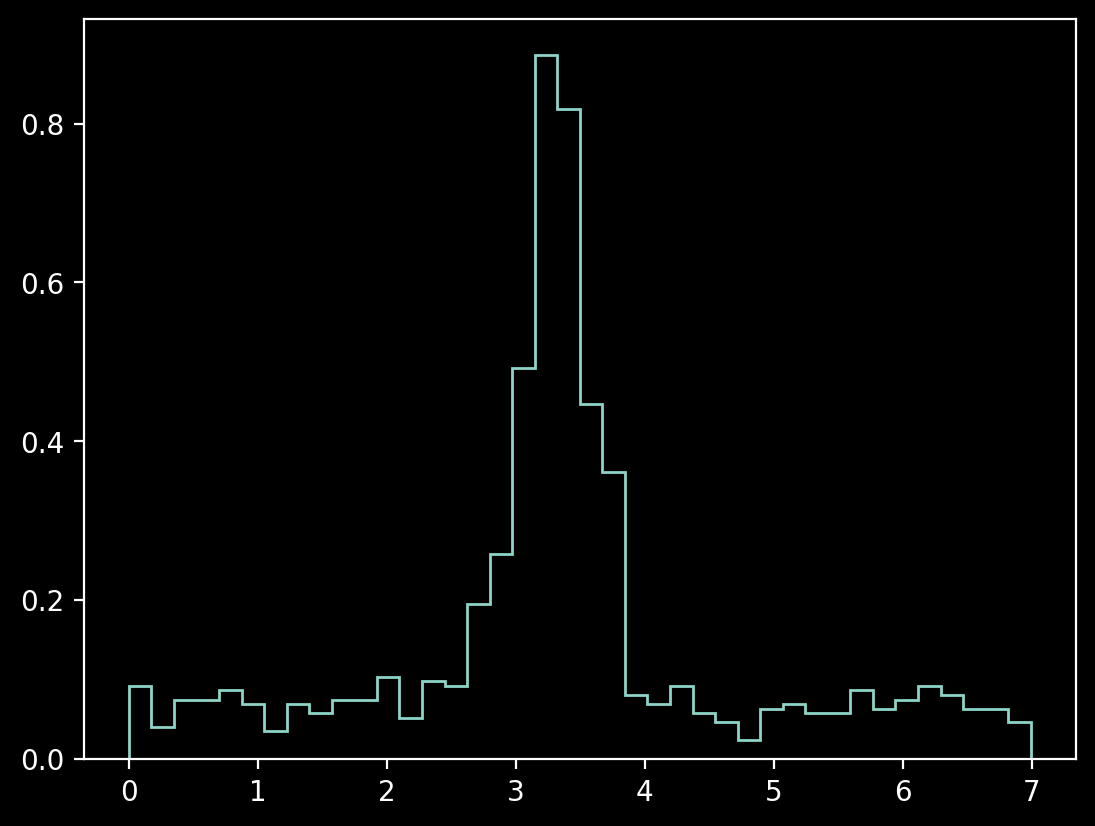

In [ ]:
plt.hist(samps['p1s'][:, -4], **hist_settings)
plt.show()

In [ ]:
samps['nmodel'].sum()

Array(475, dtype=int64)